### Parametric Name Generation With RNN (PyTorch)

#### Data Set up

In [12]:
from io import open
import glob
import os
import unicodedata
import string

In [13]:
all_letters = string.ascii_letters + ".,;'-"
n_letters = len(all_letters) + 1  # EOS added

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))


# categories: 18 ['Scottish', 'Greek', 'English', 'Czech', 'French', 'Irish', 'Arabic', 'Dutch', 'Chinese', 'Russian', 'Portuguese', 'Italian', 'Spanish', 'Korean', 'Polish', 'German', 'Japanese', 'Vietnamese']
O'Neal


In [16]:
category_lines["Russian"][:5]

['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin']

#### Creating the Network
The author of the tutorial extended the idea of vanila RNN adding more compexity o2o, dropout etc. But it's fine.<br>
It's also very cool how we can specify category (nationality) and have more fun here!<br>
<img src="https://i.imgur.com/jzVrf7f.png" width=50%><br>
Overall architecture

In [57]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(output_size + hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [58]:
import random
def random_choice(l):
    return l[random.randint(0, len(l)-1)]

def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

In [59]:
random_training_pair()

('Arabic', 'Said')

In [71]:
def categorytensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One hot encoding
def input_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

In [72]:
def randomTrainingExample():
    category, line = random_training_pair()
    category_tensor = categorytensor(category)
    input_line_tensor = input_tensor(line)
    target_line_tensor = target_tensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

#### Training

In [77]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    loss = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = loss_fn(output, target_line_tensor[i])
        loss += l
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)
    return output, loss.item() / input_line_tensor.size(0)

In [86]:
rnn = RNN(n_letters, 128, n_letters)
n_iters = 150_000
print_every = 5_000
plot_every = 500
all_losses = []
total_loss = 0

for iter in range(1, n_iters+1):
    ouptut, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print(f"Iter: {iter} | Loss: {loss}")
    
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

Iter: 5000 | Loss: 2.5938730239868164
Iter: 10000 | Loss: 2.606729030609131
Iter: 15000 | Loss: 2.352198918660482
Iter: 20000 | Loss: 2.2943435668945313
Iter: 25000 | Loss: 2.3943713506062827
Iter: 30000 | Loss: 2.1191885471343994
Iter: 35000 | Loss: 2.544705867767334
Iter: 40000 | Loss: 2.343104468451606
Iter: 45000 | Loss: 1.7815914154052734
Iter: 50000 | Loss: 2.5056784947713218
Iter: 55000 | Loss: 2.224259853363037
Iter: 60000 | Loss: 2.810243034362793
Iter: 65000 | Loss: 1.8739267587661743
Iter: 70000 | Loss: 2.272632122039795
Iter: 75000 | Loss: 1.8914262226649694
Iter: 80000 | Loss: 2.510128657023112
Iter: 85000 | Loss: 2.7222954432169595
Iter: 90000 | Loss: 2.3370467594691684
Iter: 95000 | Loss: 1.9627718244280135
Iter: 100000 | Loss: 2.405247824532645
Iter: 105000 | Loss: 1.7545657839093889
Iter: 110000 | Loss: 2.917559814453125
Iter: 115000 | Loss: 1.8657133102416992
Iter: 120000 | Loss: 2.208647918701172
Iter: 125000 | Loss: 1.9650532404581706
Iter: 130000 | Loss: 1.28096508

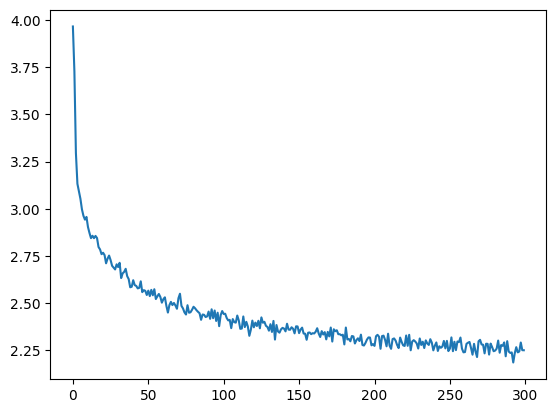

In [87]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [88]:
max_len = 20

def sample(category, start_letter="A"):
    with torch.inference_mode():
        category_tensor = categorytensor(category)
        input = input_tensor(start_letter)
        hidden = rnn.init_hidden()

        output_name = start_letter

        for i in range(max_len):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters -1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = input_tensor(letter)
        return output_name

In [89]:
def samples(category, start_letters="ABC"):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [90]:
samples("German", "DUE")

Deller
Uerter
Erin
